<a href="https://colab.research.google.com/github/nabasaisaac/EcoBot/blob/main/Train_YOLO_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Verify NVIDIA GPU Availability**

Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting one of the GPU options in the Hardware accelerator section. Click Play on the following code block to verify that the NVIDIA GPU is present and ready for training.

In [2]:
!nvidia-smi

Tue Feb 17 17:25:37 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1.&nbsp;Upload Image Dataset and Prepare Training Data

Next, we'll upload our dataset and prepare it for training with YOLO. We'll split the dataset into train and validation folders, and we'll automatically generate the configuration file for training the model.

## 1.1 Split images into train and validation folders

At this point, whether you used Option 1, 2, or 3, you should be able to click the folder icon on the left and see your `data.zip` file in the list of files. Next, we'll unzip `data.zip` and create some folders to hold the images. Run the following code block to unzip the data.

In [3]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

# DATASET SPLITTER – TRAIN / VALIDATION / TEST

In [4]:
# What this does:
#   1. Finds all images in your data_path/images folder
#   2. Shuffles them (reproducible if you set random_seed)
#   3. Splits into Train / Val / Test folders
#   4. Copies images + matching .txt label files (skips labels if they don't exist)
#   5. Creates clean folder structure under ./data/train, ./data/validation, ./data/test
#
# Why this matters for your model:
#   - Train   → model learns
#   - Val     → you tune hyperparameters and stop early to avoid overfitting
#   - Test    → final unbiased score (never used during training/tuning)

from pathlib import Path
import random
import shutil

data_path = Path("/content/custom_data")


train_percent = 0.70   # 70% for training
val_percent   = 0.15   # 15% for validation
# Test gets the remaining 15% automatically

random_seed = 42       # Set a number for reproducible splits (same split every run)
                       # Set to None if you want a different random split each time

# Common image extensions (add/remove if needed)
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}

# =============================================================================

# --------------------- Basic checks ---------------------
if not data_path.is_dir():
    raise FileNotFoundError(f"❌ Folder not found: {data_path}")

images_folder = data_path / "images"
labels_folder = data_path / "labels"          # optional – code works even if missing

if not images_folder.is_dir():
    raise FileNotFoundError(f"❌ 'images' folder not found inside {data_path}")

test_percent = 1.0 - train_percent - val_percent
if test_percent < 0.01:
    raise ValueError("Train + Val percentages must leave at least 1% for the test set")

print(f"📊 Planned split → Train: {train_percent:.0%} | Val: {val_percent:.0%} | Test: {test_percent:.0%}")

# --------------------- Create output folders ---------------------
base = Path.cwd() / "data"                    # creates ./data in your current notebook folder

folders = [
    base / "train/images",       base / "train/labels",
    base / "validation/images",  base / "validation/labels",
    base / "test/images",        base / "test/labels"
]

for folder in folders:
    folder.mkdir(parents=True, exist_ok=True)

# --------------------- Load and shuffle images ---------------------
image_files = [
    p for p in images_folder.rglob("*")
    if p.is_file() and p.suffix.lower() in image_extensions
]

print(f"✅ Found {len(image_files):,} image files")

if len(image_files) == 0:
    raise ValueError("No images found in the images folder!")

# Reproducible shuffle
if random_seed is not None:
    random.seed(random_seed)
random.shuffle(image_files)

# --------------------- Calculate split sizes ---------------------
total = len(image_files)
train_size = int(total * train_percent)
val_size   = int(total * val_percent)
test_size  = total - train_size - val_size   # remainder avoids rounding errors

print(f"   → Training images   : {train_size:,}")
print(f"   → Validation images : {val_size:,}")
print(f"   → Test images       : {test_size:,}")

# Slice the shuffled list
train_list = image_files[:train_size]
val_list   = image_files[train_size : train_size + val_size]
test_list  = image_files[train_size + val_size :]

# --------------------- Helper function ---------------------
def copy_image_and_label(img_path: Path, target_img_folder: Path, target_label_folder: Path):
    """Copies one image + its matching .txt file (if it exists)"""
    # Copy image
    shutil.copy2(img_path, target_img_folder / img_path.name)

    # Copy label only if it exists (background images have no label)
    label_file = labels_folder / f"{img_path.stem}.txt"
    if label_file.exists():
        shutil.copy2(label_file, target_label_folder / label_file.name)

# --------------------- Copy the three splits ---------------------
print("\n🚀 Copying training set...")
for img in train_list:
    copy_image_and_label(img, base / "train/images", base / "train/labels")

print("🚀 Copying validation set...")
for img in val_list:
    copy_image_and_label(img, base / "validation/images", base / "validation/labels")

print("🚀 Copying test set...")
for img in test_list:
    copy_image_and_label(img, base / "test/images", base / "test/labels")

# --------------------- Final message ---------------------
print("\n🎉 SPLIT COMPLETE!")
print(f"   Train       → {base}/train")
print(f"   Validation  → {base}/validation")
print(f"   Test        → {base}/test")
print("\nYou can now point your data.yaml to these folders:")
print("   train: data/train/images")
print("   val:   data/validation/images")
print("   test:  data/test/images")

📊 Planned split → Train: 70% | Val: 15% | Test: 15%
✅ Found 1,370 image files
   → Training images   : 958
   → Validation images : 205
   → Test images       : 207

🚀 Copying training set...
🚀 Copying validation set...
🚀 Copying test set...

🎉 SPLIT COMPLETE!
   Train       → /content/data/train
   Validation  → /content/data/validation
   Test        → /content/data/test

You can now point your data.yaml to these folders:
   train: data/train/images
   val:   data/validation/images
   test:  data/test/images


# 3.&nbsp;Install Requirements (Ultralytics)

Next, we'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model.

In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.9 MB/s eta 0:00:00


# 4.&nbsp;Configure Training


There's one last step before we can run training: we need to create the Ultralytics training configuration YAML file. This file specifies the location of your train and validation data, and it also defines the model's classes. An example configuration file model is available [here](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco128.yaml).

Run the code block below to automatically generate a `data.yaml` configuration file. Make sure you have a labelmap file located at `custom_data/classes.txt`. If you used Label Studio or one of my pre-made datasets, it should already be present. If you assembled the dataset another way, you may have to manually create the `classes.txt` file (see [here](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/doc/classes.txt) for an example of how it's formatted).

In [6]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os
from pathlib import Path

def create_data_yaml(
    path_to_classes_txt: str,
    path_to_data_yaml: str,
    data_root: str = "data",      # ← "data" (relative) or absolute path like "/content/data"
    include_test: bool = True
):
    """
    Creates data.yaml for Ultralytics YOLOv8/v11 with train/val/test support.

    Reads classes.txt (one class per line) → automatically sets nc and names.
    """

    # --------------------- Read classes.txt ---------------------
    if not os.path.exists(path_to_classes_txt):
        print(f'❌ classes.txt not found at:\n   {path_to_classes_txt}')
        print('   → Create a file with one class name per line and try again.')
        return

    with open(path_to_classes_txt, 'r', encoding='utf-8') as f:
        classes = [line.strip() for line in f if line.strip()]

    nc = len(classes)

    if nc == 0:
        print("❌ No class names found in classes.txt!")
        return

    print(f'✅ Loaded {nc} classes: {classes}')

    # --------------------- Build data.yaml dictionary ---------------------
    data = {
        'path': data_root,                    # Root folder containing train/val/test
        'train': 'train/images',
        'val':   'validation/images',
        'nc':    nc,
        'names': classes
    }

    if include_test:
        data['test'] = 'test/images'          # ←←← TEST SPLIT ADDED

    # --------------------- Write YAML file ---------------------
    with open(path_to_data_yaml, 'w', encoding='utf-8') as f:
        yaml.dump(data, f, sort_keys=False, default_flow_style=False)

    print(f'🎉 data.yaml successfully created at:\n   {path_to_data_yaml}')

    # --------------------- Show the final file ---------------------
    print('\n📄 Final data.yaml contents:')
    with open(path_to_data_yaml, 'r', encoding='utf-8') as f:
        print(f.read())


# 1. Path to your classes.txt file (one class name per line)
path_to_classes_txt = '/content/custom_data/classes.txt'   # ← CHANGE TO YOUR FILE

# 2. Where to save data.yaml (usually in the root of your notebook)
path_to_data_yaml   = '/content/data.yaml'                 # ← Most people keep this

# 3. Path to the "data" folder created by the splitter
#    → Use "data" (relative) if data.yaml is next to the data folder (recommended)
#    → Or use absolute path if you prefer
data_root = "data"                                         # ← CHANGE ONLY IF NEEDED

# Run the function
create_data_yaml(
    path_to_classes_txt=path_to_classes_txt,
    path_to_data_yaml=path_to_data_yaml,
    data_root=data_root,
    include_test=True
)

print('\n✅ You can now train with:')
print('   !yolo train data=data.yaml model=yolov8m.pt epochs=50 imgsz=640')

✅ Loaded 2 classes: ['Paper', 'plastic']
🎉 data.yaml successfully created at:
   /content/data.yaml

📄 Final data.yaml contents:
path: data
train: train/images
val: validation/images
nc: 2
names:
- Paper
- plastic
test: test/images


✅ You can now train with:
   !yolo train data=data.yaml model=yolov8m.pt epochs=50 imgsz=640


# 5.&nbsp;Train Model

## 5.1 Training Parameters
Now that the data is organized and the config file is created, we're ready to start training! First, there are a few important parameters to decide on. Visit my article on [Training YOLO Models Locally](https://www.ejtech.io/learn/train-yolo-models) to learn more about these parameters and how to choose them.

**Model architecture & size (`model`):**

There are several YOLO11 models sizes available to train, including `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt`, and `yolo11xl.pt`. Larger models run slower but have higher accuracy, while smaller models run faster but have lower accuracy. I made a brief YouTube video that compares performance of different YOLO models on a Raspberry Pi 5 and a laptop with a RTX 4050 GPU, [check it out here to get a sense of their speed accuracy](https://youtu.be/_WKS4E9SmkA). If you aren't sure which model size to use, `yolo11s.pt` is a good starting point.

You can also train YOLOv8 or YOLOv5 models by substituting `yolo11` for `yolov8` or `yolov5`.


**Number of epochs (`epochs`)**

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture. If your dataset has less than 200 images, a good starting point is 60 epochs. If your dataset has more than 200 images, a good starting point is 40 epochs.


**Resolution (`imgsz`)**

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. YOLO models are typically trained and inferenced at a 640x640 resolution. However, if you want your model to run faster or know you will be working with low-resolution images, try using a lower resolution like 480x480.


## 5.2 Run Training!

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [7]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=40 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, io

The training algorithm will parse the images in the training and validation directories and then start training the model. At the end of each training epoch, the program runs the model on the validation dataset and reports the resulting mAP, precision, and recall. As training continues, the mAP should generally increase with each epoch. Training will end once it goes through the number of epochs specified by `epochs`.

> **NOTE:** Make sure to allow training to run to completion, because an optimizer runs at the end of training that strips out unneeded layers from the model.

The best trained model weights will be saved in `content/runs/detect/train/weights/best.pt`. Additional information about training is saved in the `content/runs/detect/train` folder, including a `results.png` file that shows how loss, precision, recall, and mAP progressed over each epoch.

#6.&nbsp;Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results for the first 10 images. This is a good way to confirm your model is working as expected. Click Play on the blocks below to see how your model performs.

In [8]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11s summary (fused): 101 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/205 /content/data/validation/images/00137068-WhatsApp_Image_2025-11-19_at_10.56.31_3.jpeg: 480x640 3 plastics, 54.1ms
image 2/205 /content/data/validation/images/0298d6ad-paper351.jpg: 480x640 1 Paper, 12.3ms
image 3/205 /content/data/validation/images/048c496c-paper520.jpg: 480x640 1 Paper, 12.3ms
image 4/205 /content/data/validation/images/07ce5748-paper133.jpg: 480x640 1 Paper, 12.3ms
image 5/205 /content/data/validation/images/094ff96c-paper297.jpg: 480x640 1 Paper, 12.3ms
image 6/205 /content/data/validation/images/0d91bf29-plastic201.jpg: 480x640 1 plastic, 12.3ms
image 7/205 /content/data/validation/images/0ec719ed-paper561.jpg: 480x640 1 Paper, 12.3ms
image 8/205 /content/data/validation/images/0f5980bc-IMG-20251117-WA0053.jpg: 480x640 1 plastic, 12.3ms
image 9/205 /content/data/validation/images/0f5a440f-

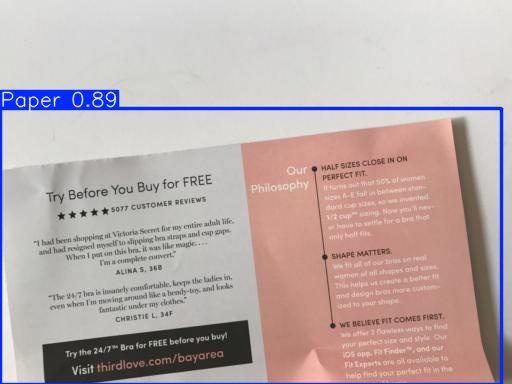

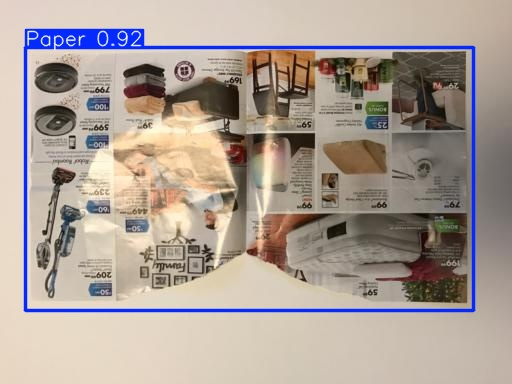

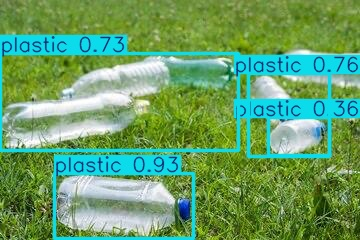

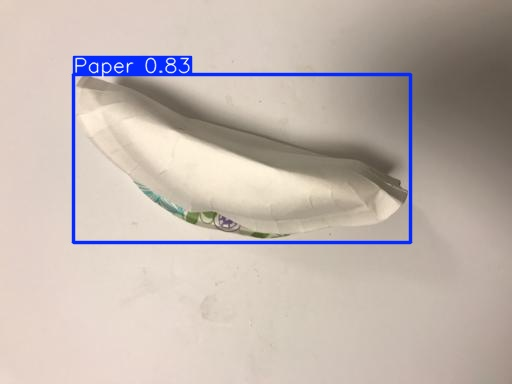

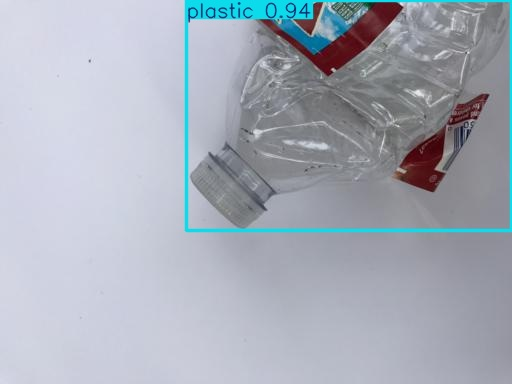

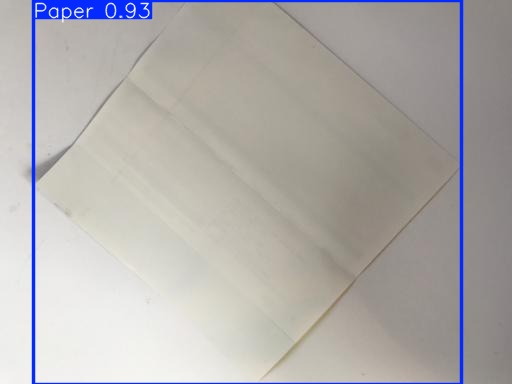

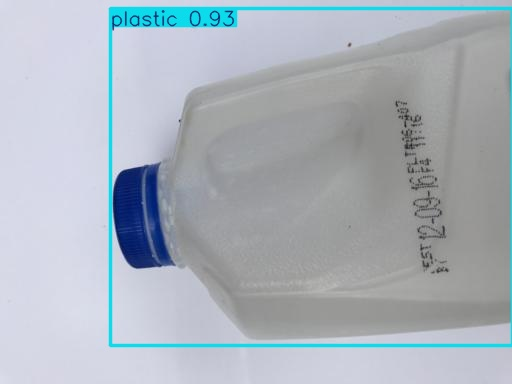

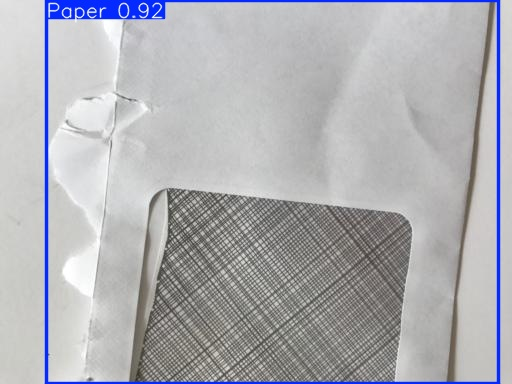

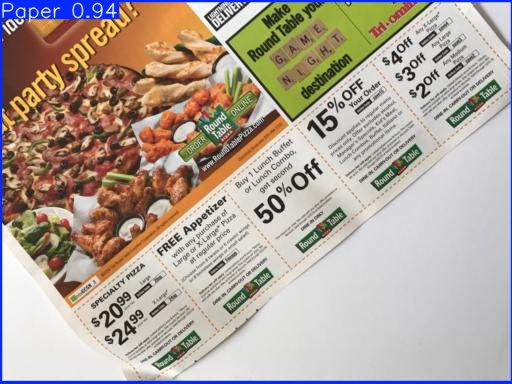

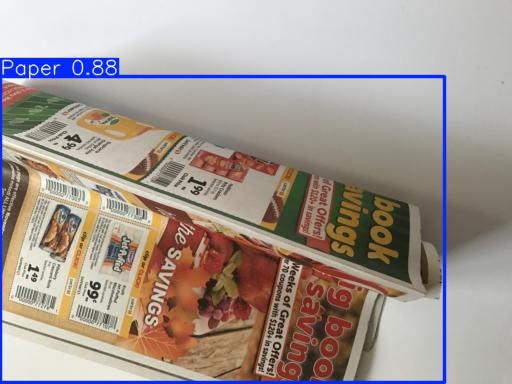

In [9]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model should draw a box around each object of interest in each image. If it isn't doing a good job of detecting objects, here are a few tips:

1. Double-check your dataset to make sure there are no labeling errors or conflicting examples.
2. Increase the number of epochs used for training.
3. Use a larger model size (e.g. `yolo11l.pt`).
4. Add more images to the training dataset. See my [dataset video](https://www.youtube.com/watch?v=v0ssiOY6cfg) for tips on how to capture good training images and improve accuracy.

You can also run the model on video files or other images images by uploading them to this notebook and using the above `!yolo detect predict` command, where `source` points to the location of the video file, image, or folder of images. The results will be saved in `runs/detect/predict`.

Drawing boxes on images is great, but it isn't very useful in itself. It's also not very helpful to just run this models inside a Colab notebook: it's easier if we can just run it on a local computer. Continue to the next section to see how to download your newly trained model and run it on a local device.

#7.&nbsp;Deploy Model

Now that your custom model has been trained, it's ready to be downloaded and deployed in an application! YOLO models can run on a wide variety of hardware, including PCs, embedded systems, and phones. Ultralytics makes it easy to convert the YOLO models to various formats (`tflite`, `onnx`, etc.) and deploy them in a variety of environments.

This section shows how to download the model and provides links to instructions for deploying it on your PC and edge devices like the Raspberry Pi.

In [11]:
# Get mAP, precision, recall etc. on validation set
model_path = '/content/runs/detect/train/weights/best.pt'
!yolo val model={model_path} data=data.yaml split=val

# For the TRUE final score (never seen during training), use test set:
# !yolo val model={model_path} data=data.yaml split=test

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11s summary (fused): 101 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 763.0±257.0 MB/s, size: 17.0 KB)
val: Scanning /content/data/validation/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 205/205 45.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.6it/s 3.6s
                   all        205        232      0.922      0.918       0.96      0.906
                 Paper         91         91      0.968      0.986      0.993      0.985
               plastic        114        141      0.876      0.851      0.927      0.826
Speed: 2.0ms preprocess, 7.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


🚀 Running full validation + generating curves...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11s summary (fused): 101 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1921.9±1578.5 MB/s, size: 98.1 KB)
val: Scanning /content/data/validation/labels.cache... 205 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 205/205 39.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.7it/s 3.5s
                   all        205        232      0.925      0.918      0.962      0.904
                 Paper         91         91      0.968      0.986      0.993      0.985
               plastic        114        141      0.882      0.851       0.93      0.823
Speed: 2.4ms preprocess, 7.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Saving /content/runs/detect/val2/predictions.json...
Results saved to /content/runs/detect

,Metric,Value
0,mAP@0.5:0.95,0.9041
1,mAP@0.5,0.9618
2,mAP@0.75,0.9350
3,Precision,0.9249
4,Recall,0.9184
5,F1-Score,0.9216
6,Inference time,7.0 ms
7,Speed (FPS),143.4


⚠️ F1_curve.csv not found – skipping best-conf calculation

📋 PER-CLASS METRICS


,Class,mAP50-95
0,Paper,0.9850
1,plastic,0.8233



📈 KEY CURVES (click to enlarge):
   F1_curve.png → not generated
   PR_curve.png → not generated
   P_curve.png → not generated
   R_curve.png → not generated

🔹 confusion_matrix.png


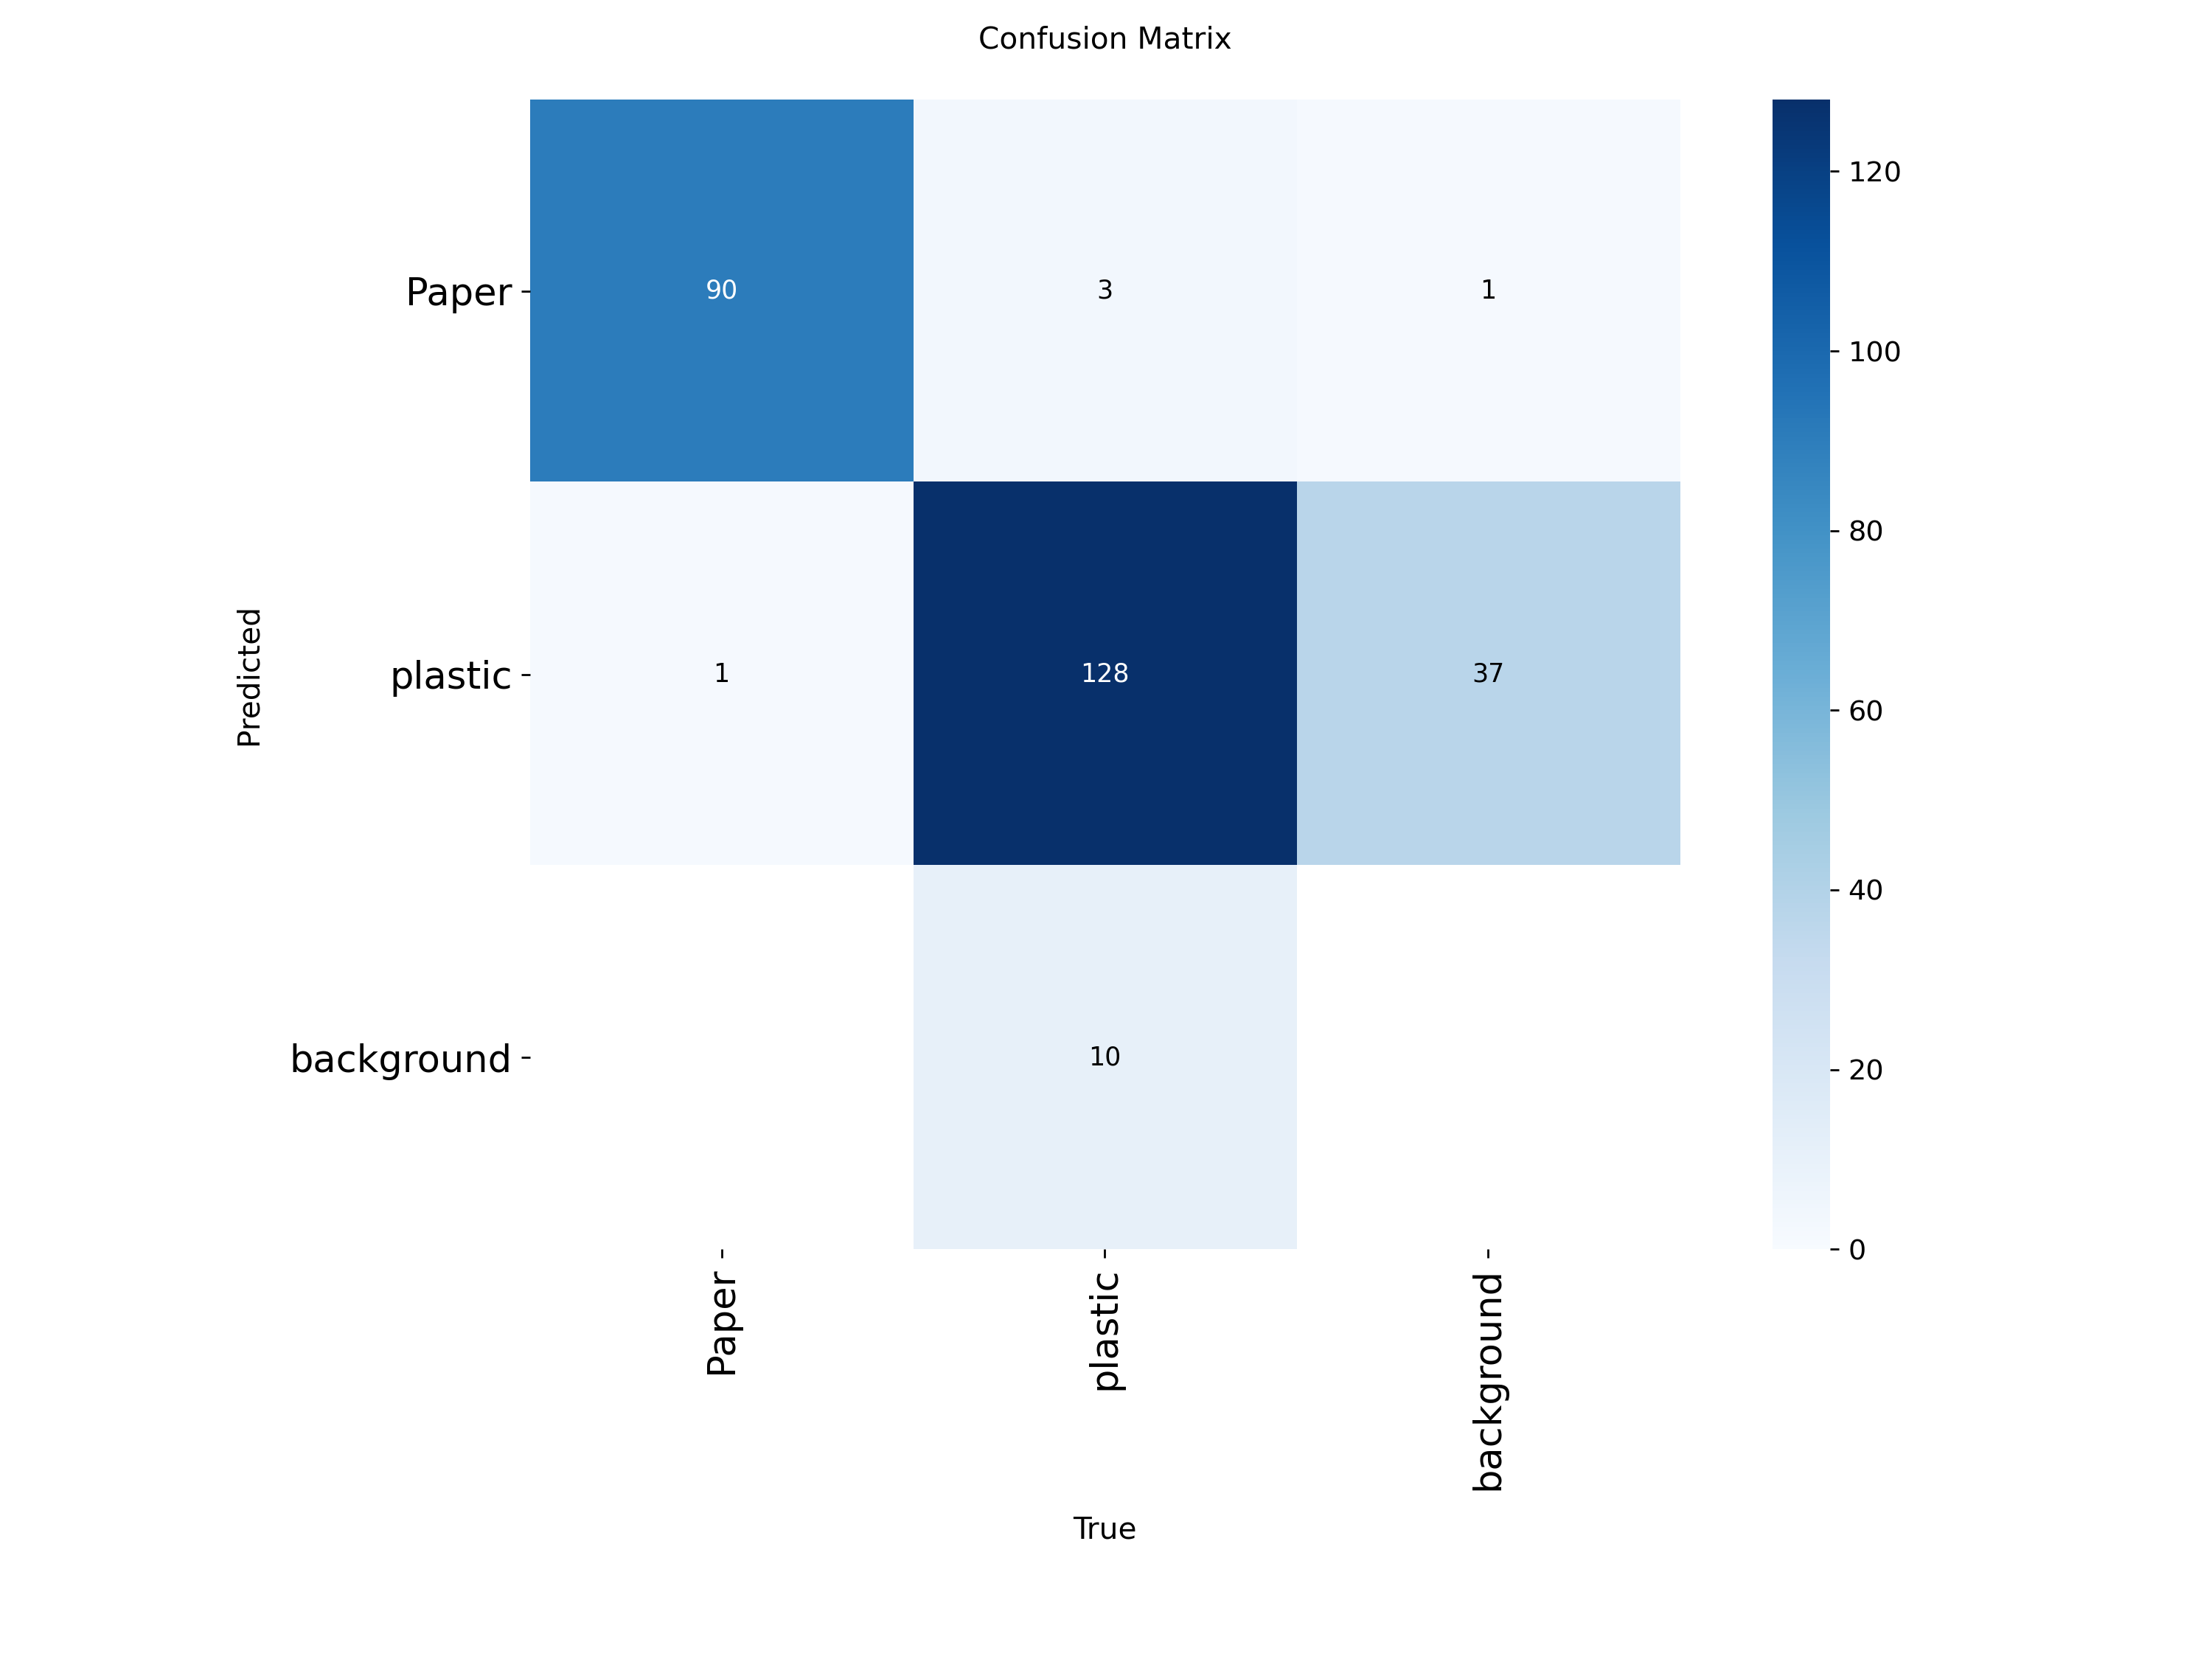


🔹 confusion_matrix_normalized.png


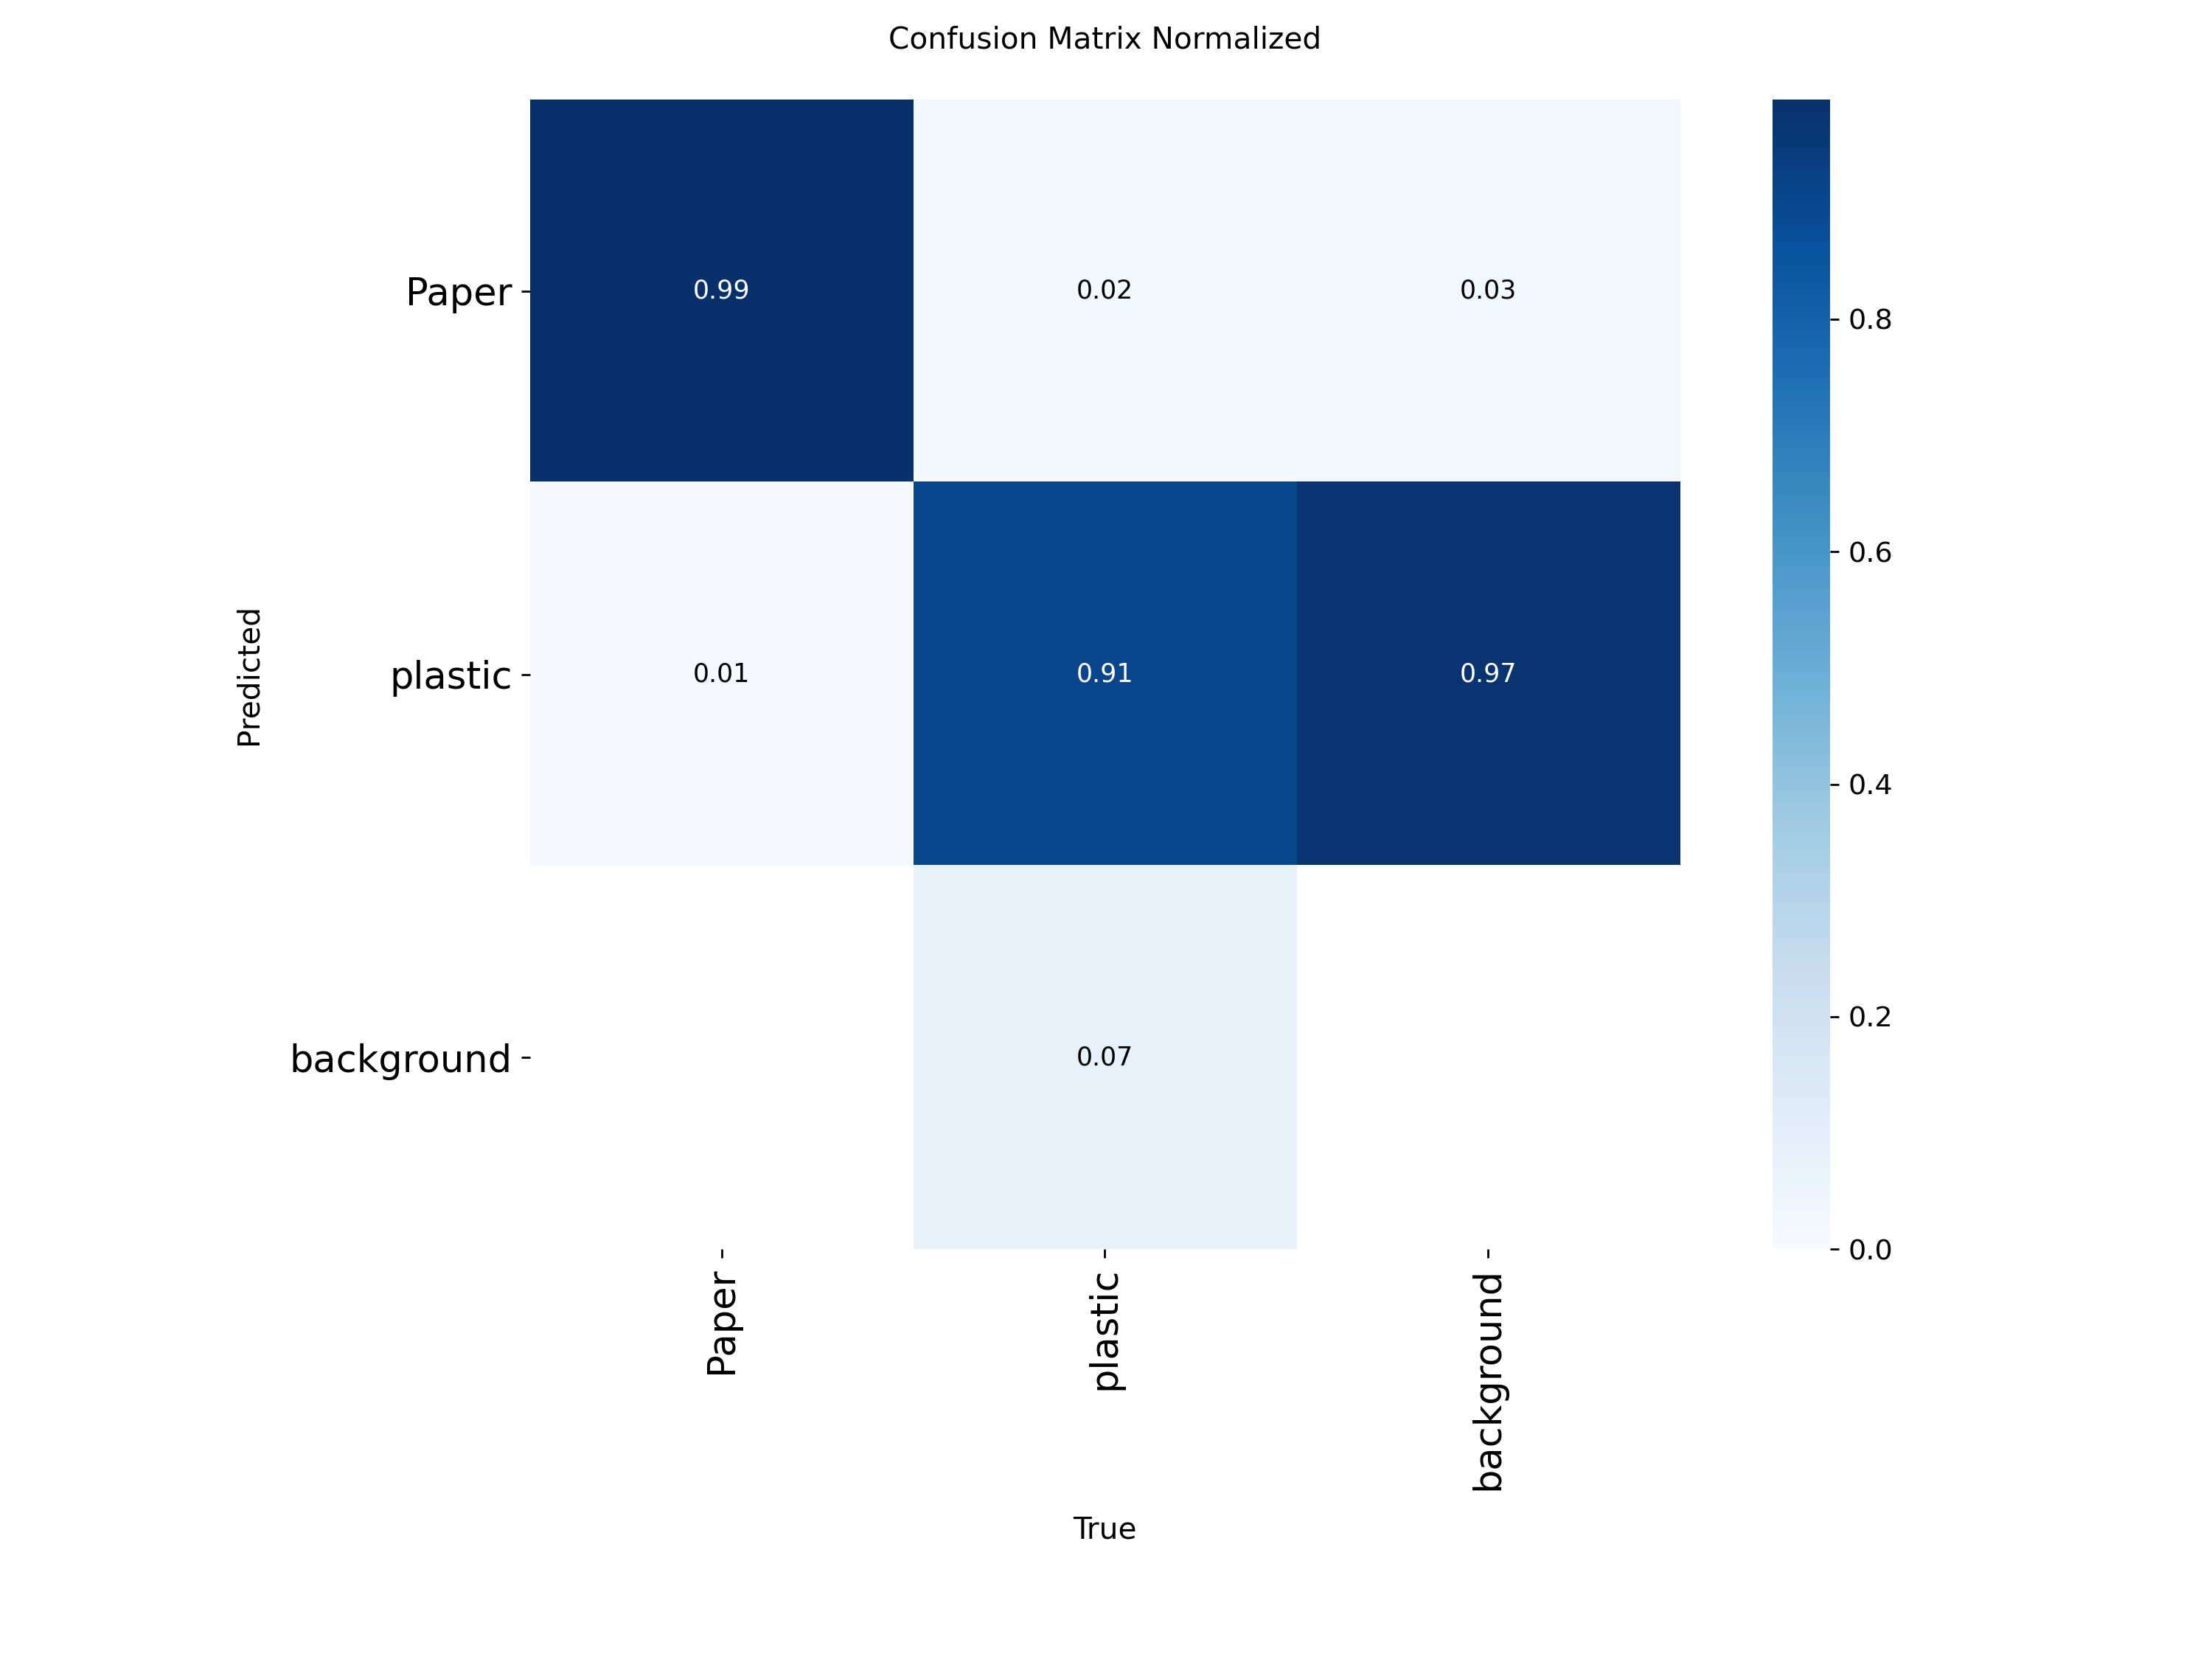

   results.png → not generated

🎉 DONE! You now have:
   • Full metrics table
   • Best confidence picked automatically
   • All curves visible
   • Ready command for your robot


In [12]:
# =============================================================================
# 📊 METRICS TABLE + CURVES + AUTOMATIC BEST CONFIDENCE (Litter Robot)
# =============================================================================
# Run this AFTER training/validation.
# It gives you:
#   1. Clean metrics table
#   2. All important curves displayed in notebook
#   3. Automatically finds the BEST confidence threshold from F1_curve
#   4. Ready-to-copy command for your robot

from ultralytics import YOLO
import pandas as pd
from IPython.display import display, Image
from pathlib import Path

# ====================== SETTINGS ======================
model_path = "runs/detect/train/weights/best.pt"   # ← change if needed
split_type = "val"                                 # change to "test" for final score

# ====================== RUN VALIDATION ======================
print("🚀 Running full validation + generating curves...")
model = YOLO(model_path)
metrics = model.val(
    data="data.yaml",
    split=split_type,
    imgsz=640,
    conf=0.001,          # low for full curves
    iou=0.6,
    plots=True,
    save_json=True
)

save_dir = Path(metrics.save_dir)
print(f"✅ All results saved in: {save_dir}\n")

# ====================== 1. OVERALL METRICS TABLE ======================
f1 = 2 * metrics.box.mp * metrics.box.mr / (metrics.box.mp + metrics.box.mr + 1e-6)

table_data = {
    "Metric": [
        "mAP@0.5:0.95", "mAP@0.5", "mAP@0.75",
        "Precision", "Recall", "F1-Score",
        "Inference time", "Speed (FPS)"
    ],
    "Value": [
        f"{metrics.box.map:.4f}",
        f"{metrics.box.map50:.4f}",
        f"{metrics.box.map75:.4f}",
        f"{metrics.box.mp:.4f}",
        f"{metrics.box.mr:.4f}",
        f"{f1:.4f}",
        f"{metrics.speed['inference']:.1f} ms",
        f"{1000 / metrics.speed['inference']:.1f}"
    ]
}

df = pd.DataFrame(table_data)
print("📊 OVERALL METRICS")
display(df.style.set_properties(**{'text-align': 'center', 'font-weight': 'bold'}))

# ====================== 2. AUTOMATIC BEST CONFIDENCE FROM F1 CURVE ======================
f1_file = save_dir / "F1_curve.csv"

if f1_file.exists():
    f1_data = pd.read_csv(f1_file)
    conf_column = f1_data.iloc[:, 0]                    # first column = confidence
    f1_scores = f1_data.iloc[:, 1:]                     # rest = F1 per class

    mean_f1 = f1_scores.mean(axis=1)                    # average F1 across all classes
    best_idx = mean_f1.idxmax()

    best_conf = conf_column.iloc[best_idx]
    best_f1   = mean_f1.iloc[best_idx]

    print(f"\n🎯 AUTOMATIC BEST CONFIDENCE")
    print(f"   Recommended conf = {best_conf:.3f}")
    print(f"   Max F1-score     = {best_f1:.4f}")
    print(f"   (This is the sweet spot for your litter robot)")

    # Ready-to-use command
    print("\n📋 Copy-paste command for deployment:")
    print(f"!yolo detect predict model={model_path} source=0 conf={best_conf:.3f} show=True")

else:
    print("⚠️ F1_curve.csv not found – skipping best-conf calculation")

# ====================== 3. PER-CLASS METRICS (if >1 class) ======================
if len(model.names) > 1:
    per_class = pd.DataFrame({
        "Class": list(model.names.values()),
        "mAP50-95": [f"{metrics.box.maps[i]:.4f}" for i in range(len(model.names))]
    })
    print("\n📋 PER-CLASS METRICS")
    display(per_class.style.set_properties(**{'text-align': 'center'}))

# ====================== 4. VISUALIZATIONS ======================
print("\n📈 KEY CURVES (click to enlarge):")
curves = ["F1_curve.png", "PR_curve.png", "P_curve.png", "R_curve.png",
          "confusion_matrix.png", "confusion_matrix_normalized.png", "results.png"]

for curve in curves:
    img_path = save_dir / curve
    if img_path.exists():
        print(f"\n🔹 {curve}")
        display(Image(filename=str(img_path), width=720))
    else:
        print(f"   {curve} → not generated")

print("\n🎉 DONE! You now have:")
print("   • Full metrics table")
print("   • Best confidence picked automatically")
print("   • All curves visible")
print("   • Ready command for your robot")

## 7.1 Download YOLO Model

First, zip and download the trained model by running the code blocks below.

The code creates a folder named `my_model`, moves the model weights into it, and renames them from `best.pt` to `my_model.pt`. It also adds the training results in case you want to reference them later. It then zips the folder as `my_model.zip`.

In [13]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/train_batch0.jpg (deflated 6%)
  adding: train/train_batch1802.jpg (deflated 13%)
  adding: train/val_batch2_labels.jpg (deflated 13%)
  adding: train/labels.jpg (deflated 23%)
  adding: train/BoxR_curve.png (deflated 14%)
  adding: train/args.yaml (deflated 53%)
  adding: train/val_batch1_labels.jpg (deflated 14%)
  adding: train/BoxP_curve.png (deflated 15%)
  adding: train/confusion_matrix.png (deflated 34%)
  adding: train/BoxPR_curve.png (deflated 20%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/train_batch1.jpg (deflated 7%)
  adding: train/val_batch0_pred.jpg (deflated 7%)
  adding: train/val_batch2_pred.jpg (deflated 12%)
  adding: train/val_batch1_pred.jpg (deflated 12%)
  adding: train/BoxF1_curve.png (deflated 12%)
  adding: train/confusion_matrix_normalized.png (deflated 32%)
 

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

## 7.2 Deploy YOLO Model on Local Devices

Next, we'll take our downloaded model and run it on a local device. This section provides instructions showing how to deploy YOLO models on various devices.

I wrote a basic Python script, `yolo_detect.py`, that shows how to load a model, run inference on an image source, parse the inference results, and display boxes around each detected class in the image. The [script](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/yolo_detect.py) gives an example of how to work with Ultralytics YOLO models in Python, and it can be used as a starting point for more advanced applications.

### 7.2.1 Deploy on PC (Windows, Linux, or macOS)

The easiest way to run Ultralytics models on a PC is using Anaconda. Anaconda sets up a virtual Python environment and allows you to easily install Ultralytics and PyTorch. It automatically installs CUDA and cuDNN, which allows you to speed up model inference with your NVIDIA GPU.

> **NOTE:** My YouTube video (link to be added) shows how to deploy your model on a PC. It walks through the following steps, so watch the video if you prefer having visual instructions.

**1. Download and Install Anaconda**

Go to the Anaconda download page at https://anaconda.com/download, click the “skip registration” button, and then download the package for your OS. When it's finished downloading, run the installer and click through the installation steps. You can use the default options for installation.

**2. Set up virtual environment**

Once it's installed, run Anaconda Prompt from the Start Bar. (If you're on macOS or Linux, just open a command terminal).

Issue the following commands to create a new Python environment and activate it:

```
conda create --name yolo-env1 python=3.12 -y
conda activate yolo-env1
```

Install Ultralytics (which also installs import libraries like OpenCV-Python, Numpy, and PyTorch) by issuing the following command:

```
pip install ultralytics
```

If you have an NVIDIA GPU, you can install the GPU-enabled version of PyTorch by issuing the following command:

```
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
```

**3. Extract downloaded model**
Take the `my_model.zip` file you downloaded in Step 7.1 and unzip it to a folder on your PC. In the Anaconda Prompt terminal, move into the unzipped folder using:

```
cd path/to/folder
```

**4. Download and run yolo_detect.py**

Download the `yolo_detect.py` script into the `my_model` folder using:

```
curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py
```

Alright! We're ready to run the script. To run inference with a yolov8s model on a USB camera at 1280x720 resolution, issue:

```
python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720
```

A window will appear showing a live feed from your webcam with boxes drawn around detected objects in each frame.

You can also run the model on an video file, image, or folder of images. To see a full list of arguments for `yolo_detect.py`, issue `python yolo_detect.py --help` or see the [README file](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/README.md).




### 7.2.2 Deploy on Raspberry Pi

Keep an eye out for an article showing how to convert YOLO models to NCNN format and run them on the Raspberry Pi!

# 8.&nbsp;Conclusion

Congratulations! You've successfully trained and deployed a YOLO object detection model. 😀

Next, you can extend your application beyond just drawing boxes and counting objects. Add functionality like logging the number of objects detected over time or taking a picture when certain objects are detected. Check out some example applications at our GitHub repository: https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models

Thanks for working through this notebook, and good luck with your projects!

# Appendix: Common Errors

If you run into any errors working through this notebook, please do the following:


- Double-check that the dataset files are set up in the correct folder structure
- Make sure there are no typos or errors in your labelmap file
- Google search the error to look for solutions

If none of those help, please submit an [Issue](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/issues) on the GitHub page. In this section, I will add resolutions to common errors as they come up.